<a href="https://colab.research.google.com/github/03Fede/Modelo-de-Clasificaci-n-Supervisada-Basado-en-XGBoost/blob/main/Modelo_de_Clasificaci%C3%B3n_Supervisada_Basado_en_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:27:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Mejores hiperparámetros: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Accuracy: 0.65
F1-Score: 0.3225806451612903
ROC-AUC: 0.5527950310559007

Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.79      0.74      0.76        46
           1       0.29      0.36      0.32        14

    accuracy                           0.65        60
   macro avg       0.54      0.55      0.54        60
weighted avg       0.67      0.65      0.66        60



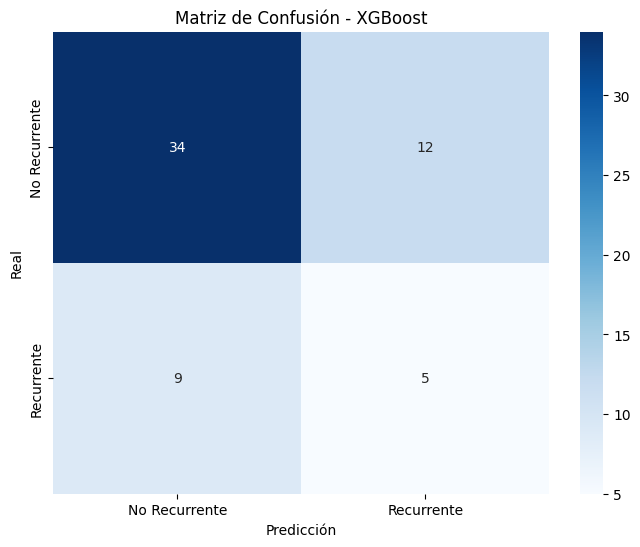

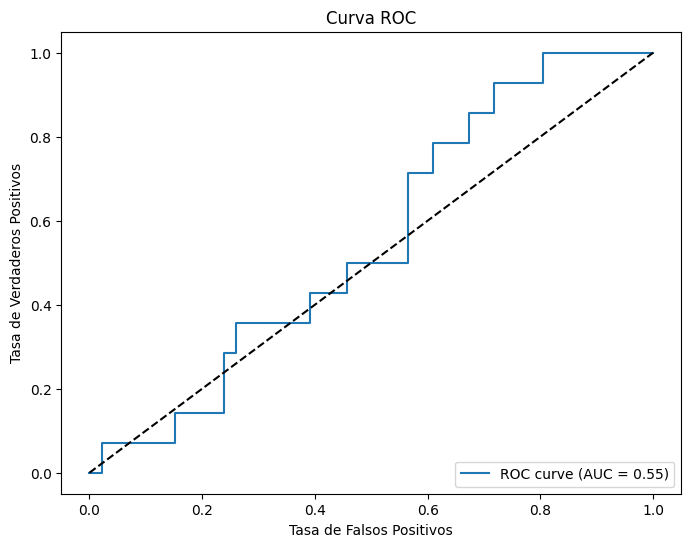

In [1]:
!pip install scikit-learn==1.2.2 xgboost

# Importar librerías necesarias
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Fijar semilla para reproducibilidad
np.random.seed(42)

# Crear dataset ficticio
data_ficticio = pd.DataFrame({
    'Edad': np.random.randint(18, 70, 200),
    'Nacionalidad': np.random.choice(['Argentina', 'Chile', 'México', 'EE.UU.', 'Brasil'], 200),
    'Tipo_Paquete': np.random.choice(['Económico', 'Premium', 'De lujo'], 200),
    'Dias_Viaje': np.random.randint(3, 21, 200),
    'Destino': np.random.choice(['Cancún', 'Bariloche', 'Río de Janeiro', 'Machu Picchu', 'Patagonia'], 200),
    'Calificacion': np.random.randint(1, 6, 200),
    'Cliente_Recurrente': np.random.choice([0, 1], 200, p=[0.7, 0.3])  # 30% de clientes recurrentes
})

# Separar características (X) y variable objetivo (y)
X = data_ficticio.drop(columns=['Cliente_Recurrente'])
y = data_ficticio['Cliente_Recurrente']

# Codificar variables categóricas
categorical_features = ['Nacionalidad', 'Tipo_Paquete', 'Destino']
encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
X_encoded = pd.DataFrame(
    encoder.fit_transform(X[categorical_features]).toarray(),
    columns=encoder.get_feature_names_out(categorical_features)
)

# Escalar variables numéricas
numerical_features = ['Edad', 'Dias_Viaje', 'Calificacion']
scaler = StandardScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(X[numerical_features]),
    columns=numerical_features
)

# Combinar datos procesados
X_prepared = pd.concat([X_scaled, X_encoded], axis=1)

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_prepared, y, test_size=0.3, random_state=42)

# Configurar el modelo XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Definir los hiperparámetros para GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Búsqueda de hiperparámetros
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='accuracy', cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Mejor modelo
best_model = grid_search.best_estimator_
print("Mejores hiperparámetros:", grid_search.best_params_)

# Evaluación del modelo
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1-Score:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("\nReporte de Clasificación:\n", classification_report(y_test, y_pred))

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Recurrente', 'Recurrente'], yticklabels=['No Recurrente', 'Recurrente'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión - XGBoost')
plt.show()

# Curva ROC
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()
